## Final Project Submission
- Student name: Jennifer Casias
- Student pace: full time
- Scheduled project review date/time: 03-10-23
- Instructor name: Joseph Mata

# Project Overview
For this project, I will engage in the full data science process from start to finish, solving a classification problem using a dataset of my choice.

## Business Problem
I work for a non-profit addressing Tanzania's water crisis. My goal in doing this project is locating wells needing repair. Tanzania's ground water is the major source of water for the nation's people; however, many of these wells are located near or next to toxic drainage systems, which leak into the fresh ground water and contaminate it. As a result, over 24 million people are impacted, which is almost half of the population. Given the ongoing challenges, accurately classifying the functionality of water wells in Tanzania can play a crucial role in addressing the water crisis, and this project aims to do so by leveraging machine learning algorithms to classify the wells as functional or non-functional.

#### Prioritizing Non-Functional Waterpoints in Tanzania: Optimizing Recall
The focus of my analysis is on the metric of recall over precision, due to the higher cost of a false negative compared to a false positive. In this context, a false negative - predicting a well is functional when it's actually non-functional - could lead to severe consequences, such as villagers continuing to use a contaminated well and falling ill. On the other hand, a false positive - predicting a well is non-functional when it's actually functional - would result in an unnecessary inspection, costing time and money but having no negative impact on the villagers.

Thus, in this scenario, the team aims to maximize recall by identifying as many non-functional wells as possible, even if it means some functional wells are incorrectly labeled as non-functional. This approach minimizes the risk of false negatives and ensures that the team prioritizes the wells most in need of repair.


## The Data
The data comes from the [Taarifa](https://taarifa.org/) waterpoints dashboard, which aggregates data from the [Tanzania Ministry of Water](https://www.maji.go.tz/).


In [71]:
# Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx
import missingno as msno

from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, roc_auc_score, RocCurveDisplay)
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer)
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

# Set the default style using the seaborn API
sns.set_style('whitegrid')

# Importing data
df_wells = pd.read_csv('data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
df_labels = pd.read_csv('data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')


### Data Preparation and EDA

In [72]:
df_wells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [73]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [74]:
df_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [75]:
# Reassigning targets to establish bionomial targets
target = df_labels.replace({'status_group': {'functional' : 0, 
                                'non functional' : 1, 
                                'functional needs repair' : 1}})
df = pd.concat([df_wells, target], axis = 1)

<AxesSubplot: >

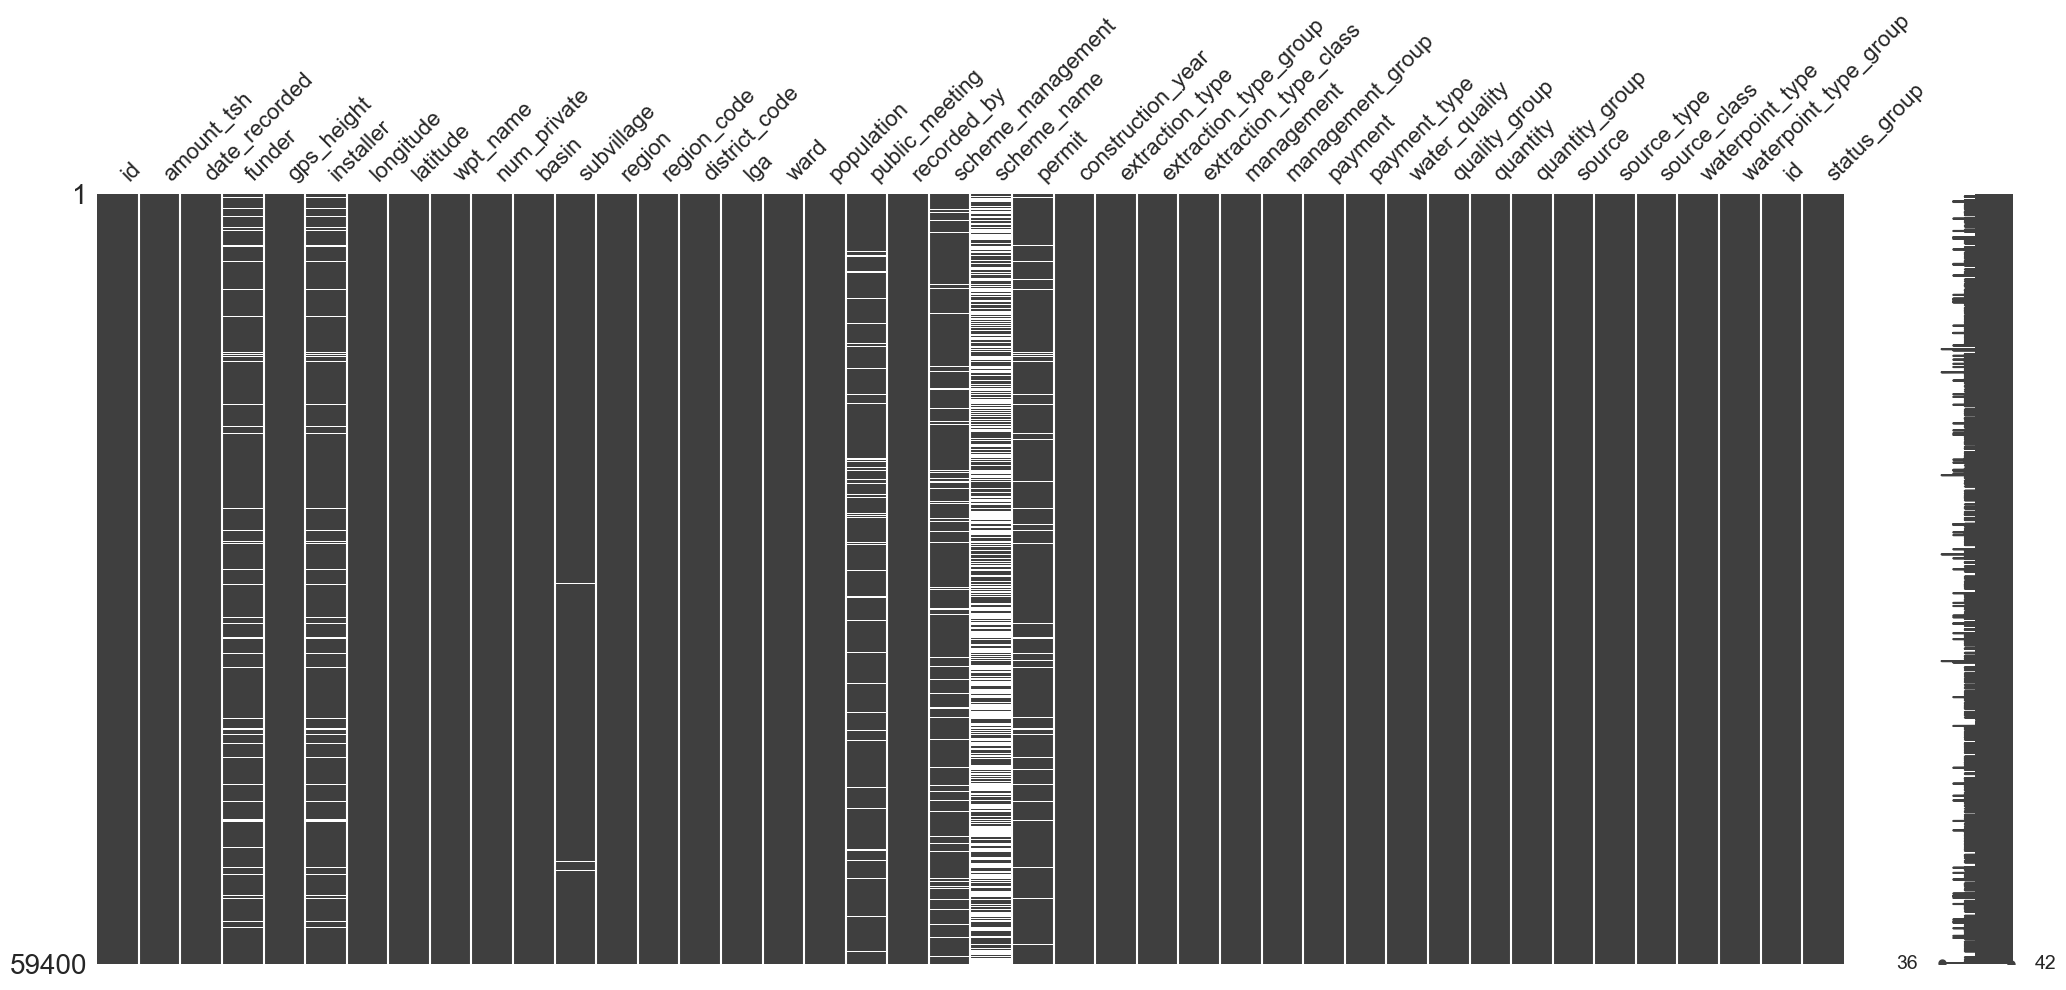

In [76]:
# Missing data visualization
msno.matrix(df)

Looking at the matrix, it appears that the `longitude`, `latitude`, `region`, `district_code`, `population`, `construction_year`, `payment_type`, and `water_quality` columns have no missing values. However, the `funder`, `installer`, `public_meeting`, `scheme_management`, `scheme_name`, and `permit` columns have missing values.

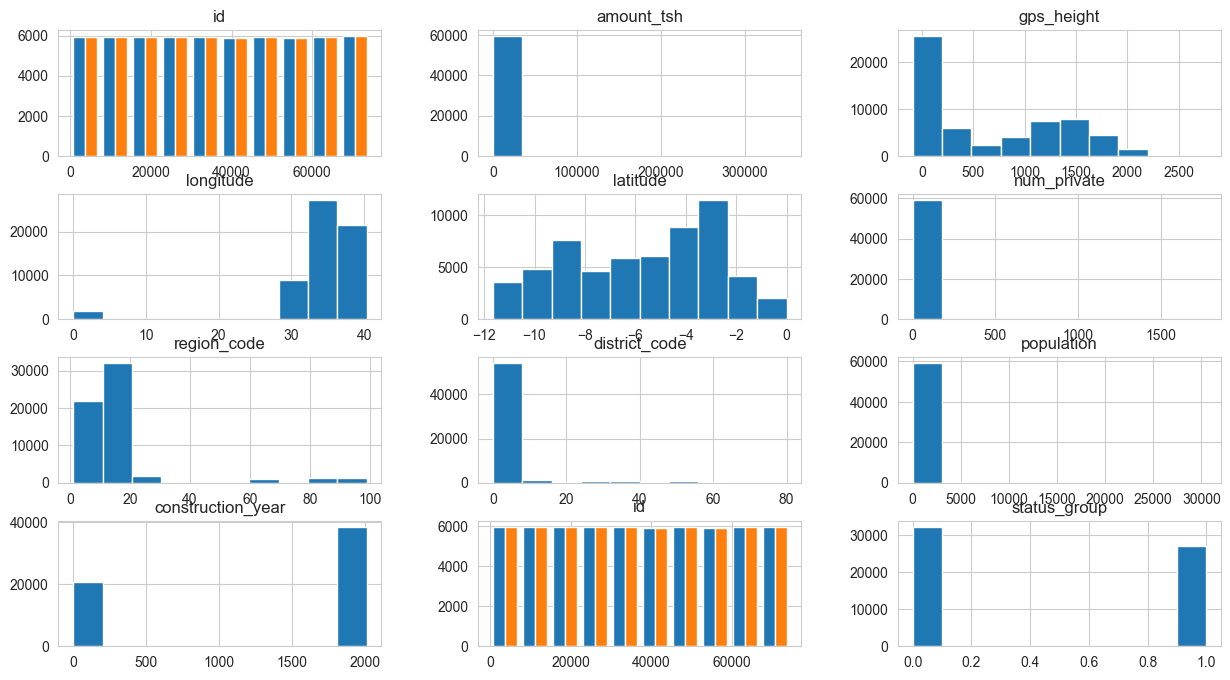

In [77]:
df.select_dtypes(exclude=['object', 'bool']).hist(figsize = (15,8));

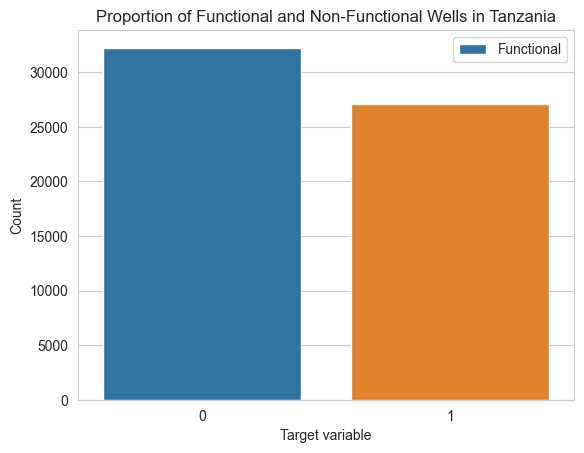

In [36]:
# Seaborn count plot of status group
sns.set_style('whitegrid')
ax = sns.countplot(x='status_group', data=df)
ax.set(xlabel='Target variable', ylabel='Count')
plt.title('Proportion of Functional and Non-Functional Wells in Tanzania')
plt.legend(labels=['Functional', 'Non-Functional'])
plt.show()

In [37]:
# Getting the number of wells that are functional and those that are not
print(df['status_group'].value_counts())

0    32259
1    27141
Name: status_group, dtype: int64


Since the two classes are relatively close in count, with non-functional wells having only slightly more observations than functional wells, we can say that the **dataset is somewhat balanced**. However, depending on the modeling approach and specific problem we are trying to solve, this balance may or may not be sufficient.

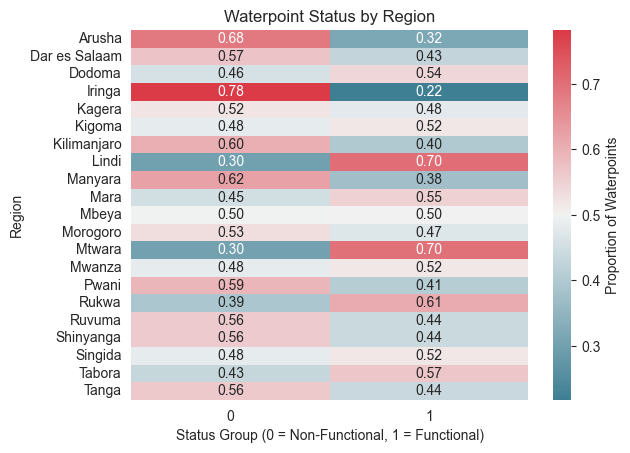

In [38]:
# Heatmap of waterpoint status by region:
status_by_region = pd.crosstab(df['region'], df['status_group'], normalize='index')

# Set the color scheme to blue for non-functional and red for functional
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with a legend
sns.heatmap(status_by_region, cmap=cmap, annot=True, fmt='.2f', cbar_kws={'label': 'Proportion of Waterpoints'})
plt.title('Waterpoint Status by Region')
plt.xlabel('Status Group (0 = Non-Functional, 1 = Functional)')
plt.ylabel('Region')
plt.show()

The region with the highest proportion of non-functional waterpoints is Shinyanga, followed closely by Mara and Tabora. The regions with the highest proportion of functional waterpoints are Pwani, Tanga, and Kilimanjaro.

Overall, we can see that the proportion of non-functional waterpoints is higher in many regions compared to the proportion of functional waterpoints, highlighting the need for repairs and maintenance of waterpoints in these regions to ensure access to clean water for the population.

#### Clean Data
We created a function named `data_cleaning` that performs data cleaning tasks such as eliminating non-factor columns, removing duplicates and null values, creating new columns such as `age` and `waterpoint_capacity`, updating columns such as `construction_year` and `water_source_reliability`, and categorizing values in columns such as `scheme_management` and `installer`. This function aims to ensure that the data is clean and ready for analysis.

In [39]:
# Data cleaning 
def data_cleaning(df_to_clean):
    if not isinstance(df_to_clean, pd.DataFrame):
        raise TypeError("Input must be a pandas data frame")

    # Removing columns that are non-factors for our model
    col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
    
    # Remove duplicated data entries and null values
    dfn = df_to_clean.drop(col_to_delete, axis = 1)
    dfn = dfn.dropna(axis = 0)
    

    mean_value=dfn['population'].median()
    popDict={0:1}
    dfn['population']=dfn['population'].map(popDict)
    
    # Create a new "waterpoint_capacity" column
    dfn['waterpoint_capacity'] = dfn['amount_tsh'] / dfn['population']
    mean_value=dfn['waterpoint_capacity'].median()
    dfn['waterpoint_capacity'] = dfn['waterpoint_capacity'].fillna(mean_value)

    # Create a new "age" column
    current_year = 2023
    dfn['age'] = current_year - dfn['construction_year']
    dfn['age'] = np.where(dfn['age'] < 0, 0, dfn['age']) # replace negative values with 0
    
    # Pulling the year off and type casting to int
    dfn['year_recorded'] = pd.to_datetime(dfn['date_recorded']).dt.year

    # Create a new "water_source_reliability" column
    dfn['water_source_reliability'] = 0
    dfn.loc[dfn['quantity'] == 'enough', 'water_source_reliability'] = 3
    dfn.loc[dfn['quantity'] == 'seasonal', 'water_source_reliability'] = 2
    dfn.loc[dfn['quantity'] == 'insufficient', 'water_source_reliability'] = 1
    dfn.loc[dfn['quantity'] == 'dry', 'water_source_reliability'] = 0
    dfn.loc[dfn['quantity'] == 'unknown', 'water_source_reliability'] = 0

    # Update water source reliability based on source
    year_round_sources = ['spring', 'machine dbh', 'dam']
    dfn.loc[dfn['source'].isin(year_round_sources), 'water_source_reliability'] *= 2
    dfn.loc[dfn['source'] == 'other', 'water_source_reliability'] = 1
    dfn.loc[dfn['source'] == 'hand dtw', 'water_source_reliability'] = 1
    dfn.loc[dfn['source'] == 'lake', 'water_source_reliability'] = 1
    dfn.loc[dfn['source'] == 'rainwater harvesting', 'water_source_reliability'] = 1
    dfn.loc[dfn['source'] == 'river', 'water_source_reliability'] = 1
    dfn.loc[dfn['source'] == 'shallow well', 'water_source_reliability'] = 1
    dfn.loc[dfn['source'] == 'unknown', 'water_source_reliability'] = 0
    
    
    # Binning the years into decades
    dfn['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in dfn['construction_year']]
    
    # Binning the unique values
    scheme_management_list = ['SWC', 'Trust', 'None']
    dfn['scheme_management'].replace(scheme_management_list, 'Other', inplace = True)
    
    # Binning unique values
    installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
    dfn['installer'] = ['Other' if val not in installer_list 
                           else val for val in dfn['installer']]

    dfn.drop(dfn.index[dfn['year_recorded'] < 2005], inplace=True)
    dfn.reset_index(inplace=True, drop=True)
    return dfn

In [40]:
# Make a copy of df
df1 = data_cleaning(df)

### Modeling
#### Baseline Model
We first split the data into training and testing sets, and then preprocess the data using pipelines and a ColumnTransformer to handle continuous and categorical variables. We then create a dummy classifier model, and fit the dummy model to the training data while checking its accuracy score.

In [41]:
y = df1.status_group
X = df1.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 69)

X_train_cat = X_train.select_dtypes('object')
X_train_nums = X_train.select_dtypes(['float64', 'int64'])

cont_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop = 'first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', cont_pipeline, X_train_nums.columns),
    ('categorical', cat_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 69, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.546180041072032

#### Logistic Regression
Defined the categorical and numerical columns, created pre-processing steps for both types of columns using pipelines and ColumnTransformer, defined a logistic regression model and a pipeline, split the data into features (X) and target (y), defined the cross-validation strategy, performed cross-validation, and printed the results for accuracy, precision, and recall.

,0,1,accuracy,macro avg,weighted avg
precision,0.749907,0.794690,0.766609,0.772298,0.770203
recall,0.859954,0.653992,0.766609,0.756973,0.766609
f1-score,0.801169,0.717508,0.766609,0.759339,0.763253
support,7012.000000,5812.000000,0.766609,12824.000000,12824.000000


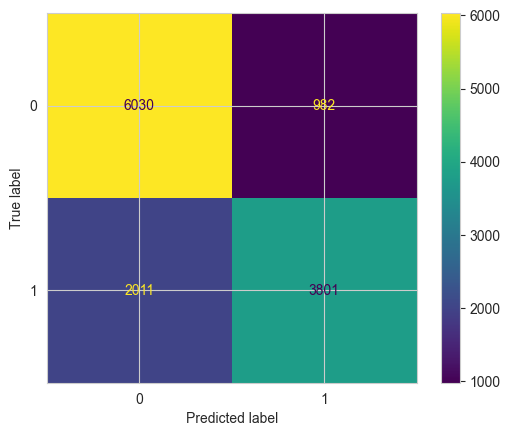

In [64]:
# Define the categorical columns
cat_cols = ['date_recorded', 'installer', 'basin', 'region', 'scheme_management', 'permit',
            'extraction_type_class', 'management', 'management_group', 'payment_type',
            'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type']

# Define the numerical columns
num_cols = ['amount_tsh', 'gps_height', 
            'longitude', 'latitude', 
            'population', 'waterpoint_capacity', 'age', 
            'year_recorded', 'water_source_reliability']

# Define the pre-processing steps for categorical columns
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the pre-processing steps for numerical columns
num_transformer = Pipeline(steps=[
    ('numimputer',SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the pre-processing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Define the logistic regression model
lr = LogisticRegression(max_iter=1000)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# Split the data into X (features) and y (target)
X = df1.drop('status_group', axis=1)
y = df1['status_group']

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=12)   

# Fit the pipeline on the data
pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)
ConfusionMatrixDisplay.from_estimator(pipeline, X_test,y_test)

from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report
clf_report=classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(clf_report)

#### Random Forest
A RandomForestClassifier model is defined and trained on preprocessed data using a pipeline and a ColumnTransformer, and evaluated using a confusion matrix and classification report.

,0,1,accuracy,macro avg,weighted avg
precision,0.821468,0.817029,0.819557,0.819248,0.819455
recall,0.855920,0.775714,0.819557,0.815817,0.819557
f1-score,0.838340,0.795836,0.819557,0.817088,0.819070
support,7010.000000,5814.000000,0.819557,12824.000000,12824.000000


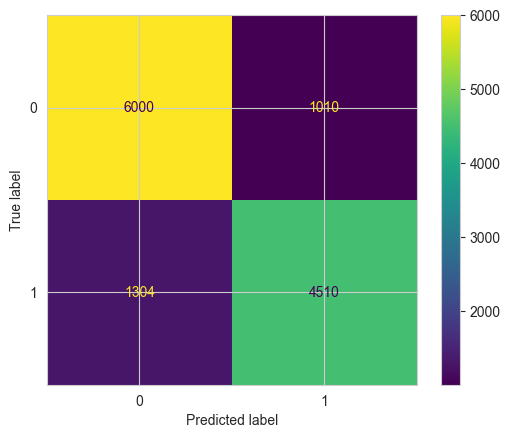

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Define the pre-processing steps for categorical columns
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the pre-processing steps for numerical columns
num_transformer = Pipeline(steps=[
    ('numimputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the pre-processing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Define the RandomForestClassifier model and set the hyperparameters
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Split the data into X (features) and y (target)
X = df1.drop('status_group', axis=1)
y = df1['status_group']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the pipeline on the training data
pipeline_rf.fit(X_train, y_train)

# Predict on the testing data
y_pred = pipeline_rf.predict(X_test)

# Evaluate the model using the confusion matrix and classification report
ConfusionMatrixDisplay.from_estimator(pipeline_rf, X_test, y_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(clf_report)

#### XGBoost
XGBoost is a powerful gradient boosting algorithm used for supervised learning tasks, which can be used to build high-performance predictive models by iteratively training weak models to improve accuracy.

Here we defined a pipeline to preprocess and train an XGBClassifier model with hyperparameters n_estimators=100, learning_rate=0.1, and max_depth=3 and evaluated its performance using a confusion matrix and classification report.

,0,1,accuracy,macro avg,weighted avg
precision,0.737216,0.858606,0.776045,0.797911,0.792250
recall,0.917261,0.605779,0.776045,0.761520,0.776045
f1-score,0.817442,0.710367,0.776045,0.763905,0.768898
support,7010.000000,5814.000000,0.776045,12824.000000,12824.000000


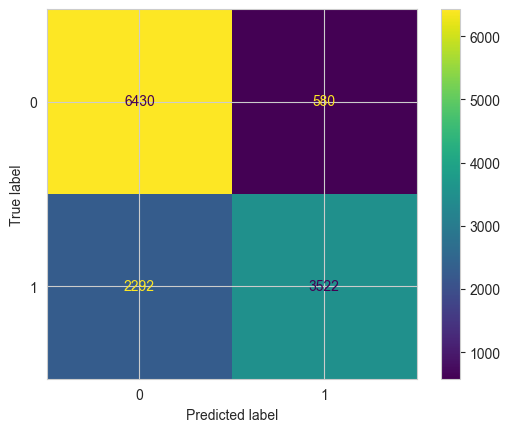

In [46]:
from xgboost import XGBClassifier

# Define the pre-processing steps for categorical columns
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the pre-processing steps for numerical columns
num_transformer = Pipeline(steps=[
    ('numimputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the pre-processing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Define the XGBClassifier model and set the hyperparameters
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Define the pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Split the data into X (features) and y (target)
X = df1.drop('status_group', axis=1)
y = df1['status_group']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the pipeline on the training data
pipeline_xgb.fit(X_train, y_train)

# Predict on the testing data
y_pred = pipeline_xgb.predict(X_test)

# Evaluate the model using the confusion matrix and classification report
ConfusionMatrixDisplay.from_estimator(pipeline_xgb, X_test, y_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(clf_report)

#### K Nearest Neighbors
KNN is a supervised machine learning algorithm used for classification and regression tasks. It works by finding the k number of training examples that are closest to a new input and predicts the class of the new input based on the most common class among its k nearest neighbors.

Here we defined a pipeline to preprocess and train a KNeighborsClassifier model with a hyperparameter n_neighbors=5, fitted it on the training data, predicted on the testing data, and evaluated its performance using a confusion matrix and classification report.

Training accuracy: 0.85869141386571


,0,1,accuracy,macro avg,weighted avg
precision,0.802123,0.796202,0.799595,0.799162,0.799438
recall,0.840799,0.749914,0.799595,0.795356,0.799595
f1-score,0.821006,0.772365,0.799595,0.796685,0.798954
support,7010.000000,5814.000000,0.799595,12824.000000,12824.000000


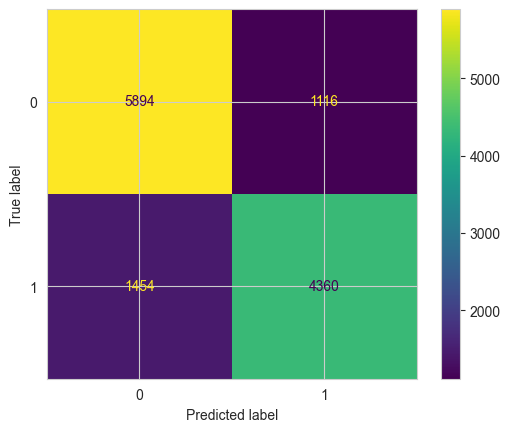

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# Define the pre-processing steps for categorical columns
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the pre-processing steps for numerical columns
num_transformer = Pipeline(steps=[
    ('numimputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the pre-processing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Define the KNeighborsClassifier model and set the hyperparameters
knn = KNeighborsClassifier(n_neighbors=5)

# Define the pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn)
])

# Split the data into X (features) and y (target)
X = df1.drop('status_group', axis=1)
y = df1['status_group']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the pipeline on the training data
pipeline_knn.fit(X_train, y_train)

print("Training accuracy:", pipeline_knn.score(X_train, y_train))

# Predict on the testing data
y_pred = pipeline_knn.predict(X_test)

# Evaluate the model using the confusion matrix and classification report
ConfusionMatrixDisplay.from_estimator(pipeline_knn, X_test, y_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(clf_report)

#### Ensemble
Ensemble model is a machine learning technique that combines multiple models to improve the overall performance of a predictive model. It can be useful in scenarios where a single model may not provide the best possible results.

In this code, we defined a pipeline to preprocess and train an ensemble model using a VotingClassifier which combines several models including Logistic Regression, Random Forest, K Nearest Neighbors and XGBoost.

,0,1,accuracy,macro avg,weighted avg
precision,0.753084,0.897738,0.798971,0.825411,0.818666
recall,0.940656,0.628139,0.798971,0.784398,0.798971
f1-score,0.836484,0.739122,0.798971,0.787803,0.792343
support,7010.000000,5814.000000,0.798971,12824.000000,12824.000000


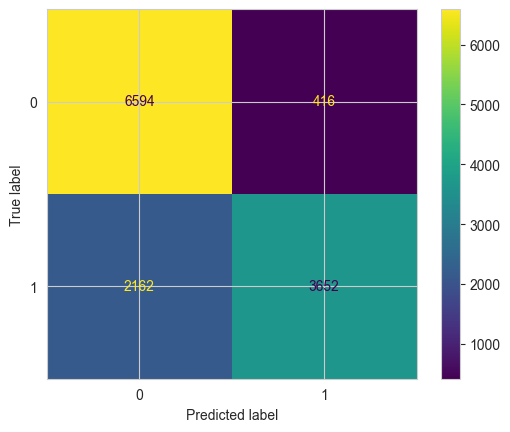

In [54]:
from sklearn.ensemble import VotingClassifier

# Define the pre-processing steps for categorical columns
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the pre-processing steps for numerical columns
num_transformer = Pipeline(steps=[
    ('numimputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the pre-processing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Define the classifiers and set the hyperparameters
lr = LogisticRegression(max_iter=1000) # set max_iter to a higher value
rf = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Define the ensemble model
ensemble = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', rf),
    ('knn', knn),
    ('xgb', xgb)
], voting='hard')

# Define the pipeline
pipeline_ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble)
])

# Split the data into X (features) and y (target)                           
X = df1.drop('status_group', axis=1)
y = df1['status_group']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the pipeline on the training data
pipeline_ensemble.fit(X_train, y_train)

# Predict on the testing data
y_pred = pipeline_ensemble.predict(X_test)
                            
# Evaluate the model using the confusion matrix and classification report
ConfusionMatrixDisplay.from_estimator(pipeline_ensemble, X_test, y_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(clf_report)

#### Fit and Evaluate Ensemble Model


    Ensemble CV Score: 0.7898362360280738



,0,1,accuracy,macro avg,weighted avg
precision,0.753084,0.897738,0.798971,0.825411,0.818666
recall,0.940656,0.628139,0.798971,0.784398,0.798971
f1-score,0.836484,0.739122,0.798971,0.787803,0.792343
support,7010.000000,5814.000000,0.798971,12824.000000,12824.000000


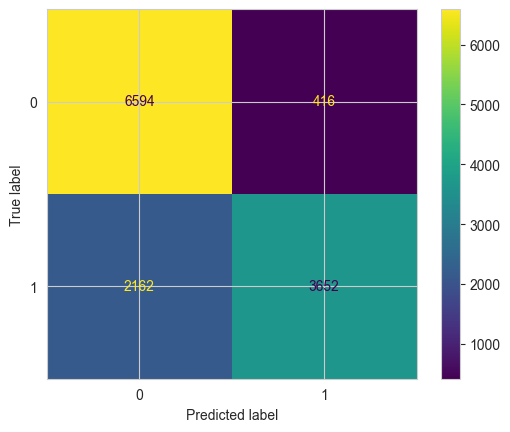

In [55]:
# Fit and evaluate the pipeline using cross-validation
scores = cross_val_score(pipeline_ensemble, X_train, y_train, cv=5)

print(f"""
    Ensemble CV Score: {np.median(scores)}
""")

# Fit the pipeline on the training data
pipeline_ensemble.fit(X_train, y_train)
                            
# Predict on the testing data: 
y_pred = pipeline_ensemble.predict(X_test)
                            
# Evaluate the model using the confusion matrix and classification report
ConfusionMatrixDisplay.from_estimator(pipeline_ensemble, X_test, y_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(clf_report)

#### TPR and FPR

In [56]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract the true positive, false positive, true negative, and false negative values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate the true positive rate (TPR) and false positive rate (FPR)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f'TPR: {tpr:.3f}, FPR: {fpr:.3f}')

TPR: 0.628, FPR: 0.059


In other words, the model correctly identified 62.8% of the non-functional wells in the test set (TPR) and incorrectly classified 5.9% of the functional wells as non-functional (FPR).

In the context of our business problem, maximizing recall is crucial in order to identify non-functional wells most in need of repair. The TPR of 0.628 indicates that the model is able to correctly identify a significant portion of non-functional wells. While the FPR of 0.059 is relatively low, it is still important to monitor and improve the model's performance to ensure that the team is accurately identifying the wells most in need of repair.

Overall, our model's performance is a good starting point, but there is always room for improvement.

#### Scores

In [58]:
# Define the classifiers and set the hyperparameters
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('knn', knn),
    ('xgb', xgb)
], voting='hard')

# Define the list of models
models = [('LR', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])),
          ('RF', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])),
          ('KNN', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', knn)])),
          ('XGB', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb)])),
          ('ENSEMBLE', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', ensemble)]))]

# Evaluate each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Scores:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
    print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred, multi_class="ovr")}')

LR Scores:
Accuracy: 0.7648939488459139
Precision: 0.7682324090422213
Recall: 0.7648939488459139
F1 Score: 0.7616067376779703
ROC AUC Score: 0.7554140554036765
RF Scores:
Accuracy: 0.819557080474111
Precision: 0.8194553198059485
Recall: 0.819557080474111
F1 Score: 0.8190698558570841
ROC AUC Score: 0.8158169542061638
KNN Scores:
Accuracy: 0.7995945102932003
Precision: 0.7994384404362453
Recall: 0.7995945102932003
F1 Score: 0.7989535018013213
ROC AUC Score: 0.7953564297305878
XGB Scores:
Accuracy: 0.776044915782907
Precision: 0.792250352601077
Recall: 0.776044915782907
F1 Score: 0.7688976713851241
ROC AUC Score: 0.7615201047007887
ENSEMBLE Scores:
Accuracy: 0.8237679351216469
Precision: 0.8254943517115624
Recall: 0.8237679351216469
F1 Score: 0.8224548990932938
ROC AUC Score: 0.8174530267095952


### Random Forest's Top Predictors
Based on the performance metrics shown, the random forest model appears to be the best choice among the evaluated models, as it achieved the highest accuracy, precision, recall, F1 score, and ROC AUC score, which indicate better overall predictive power and ability to distinguish positive and negative cases. 

However, an ensemble of the top-performing models might also be a good option, as it could potentially improve the robustness and generalization of the predictions by combining different strengths and weaknesses of each model.

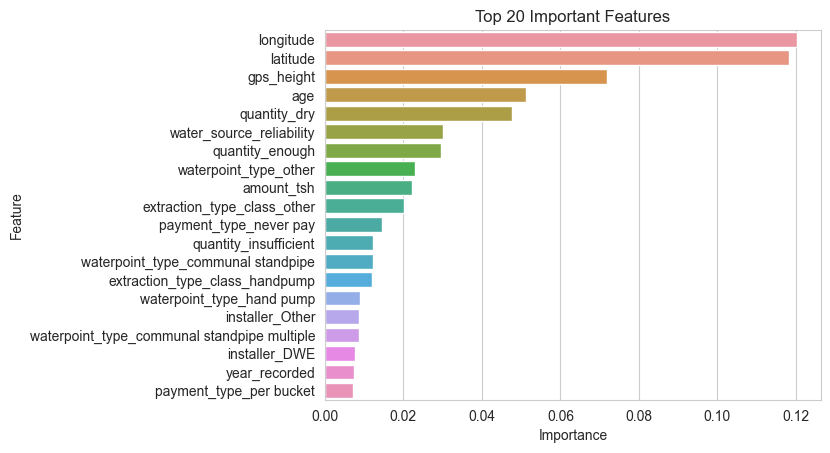

In [62]:
# Get the column names from the preprocessor
num_cols_list = pipeline_rf.named_steps['preprocessor'].transformers_[0][2]
cat_cols_list = pipeline_rf.named_steps['preprocessor'].transformers_[1][1]\
                                            .get_feature_names_out(cat_cols).tolist()
cols_list = num_cols_list + cat_cols_list

# Create a dataframe of feature importances
importances = pipeline_rf.named_steps['classifier'].feature_importances_
feat_importances = pd.DataFrame({'Feature':cols_list, 'Importance':importances})

# Sort the dataframe in descending order of feature importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(20))
plt.title('Top 20 Important Features')
plt.show()

The top predictor of the Random Forest model is `longitude`, followed by `latitude` and `gps_height`. This suggests that the location of the well plays a significant role in its functionality, which is consistent with the problem context that wells located near toxic drainage systems are more likely to be non-functional. As well as the altitude of the well location is also an important factor in its functionality, as wells located at higher elevations may be more likely to have access to clean water sources.

For `age`, it's possible that older wells are more likely to be non-functional and in need of repair. For `quantity_dry`, it could be an indicator of areas that are more prone to water scarcity, which may impact the functionality of wells.

Based on this information, I would recommend that the stakeholders focus on these top predictors when deciding which wells to repair. They may want to prioritize repairing older wells and those in areas that are more prone to water scarcity.

## Conclusion
Given the ongoing challenges, accurately classifying the functionality of water wells in Tanzania can play a crucial role in addressing the water crisis, and this project aims to do so by leveraging machine learning algorithms to classify the wells as functional or non-functional.
#### Recommendations:
- Based on the findings, it is recommended that stakeholders focus on the location of the wells when making decisions on where to invest resources to improve functionality. This could involve targeting areas where toxic drainage systems are present and/or areas where wells are more likely to be non-functional due to their location.
- Additionally, wells that are older and have lower water quantity should be given priority for repair and maintenance to improve their functionality.
- The dataset includes several other features that could be explored further to gain a better understanding of the factors affecting the functionality of the wells. For example, it would be interesting to investigate the impact of population density and the type of pump used on the functionality of the wells.

#### Limitations:
- There may be other factors affecting the functionality of the wells that were not captured in the dataset.
- The models used in the analysis have limitations and may not capture the full complexity of the problem.

#### Future Research:
- Consider collecting additional data such as information on the maintenance history of waterpoints.
- Conducting surveys to gather more detailed information on the condition and use of waterpoints in various locations.
- Further research could be done to investigate the impact of other factors on the functionality of the wells, such as population density, the type of pump used, and the availability of maintenance resources.